<a href="https://colab.research.google.com/github/mohammedhemed77/DL-Course-UDL-Book-Based-/blob/main/Implementations/Notebooks/measuring_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Measuring performance Noteook by Eng : Mohammed Hemed

####In this notebook we will cover

####1️⃣Bias-variance-tradeoff
Explain how models can underfit (high bias) or overfit (high variance) and why we need to find a balance.

####2️⃣Trian-validate-test split dataset
slice a set called validation set to optimize hyperparameters

####3️⃣Hyperparameter Tuning
Show how different hyperparameters (like learning rate,  or network depth) to help adjust this balance in real-world models.

####4️⃣MNIST-1D dataset performance measuring


# import libraries

In [29]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

#### Install MNIST 1D repository

In [2]:
# Install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-uniezmat
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-uniezmat
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14626 sha256=98ce627a3fa01728520b91b8b8213c818df299d4409e21e31d5159b7904bf038
  Stored in directory: /tmp/pip-ephem-wheel-cache-izbytdjc/wheels/d6/38/42/3d2112bc7d915f6195254ac85eb761d922d1b18f52817aa8e2
Successfully built mnist1d


####Generate training and test dataset using the MNIST1D code.
  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [5]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...


#### Some insghts about MNIST-1ddataset

In [47]:
print("Training Data Shape:", data['x'].shape,type(data['x']))
print("Training Labels Shape:", data['y'].shape,type(data['y']))
print("Test Data Shape:", data['x_test'].shape,type(data['x_test']))
print("Test Labels Shape:", data['y_test'].shape,type(data['y_test']))

Training Data Shape: (4000, 40) <class 'numpy.ndarray'>
Training Labels Shape: (4000,) <class 'numpy.ndarray'>
Test Data Shape: (1000, 40) <class 'numpy.ndarray'>
Test Labels Shape: (1000,) <class 'numpy.ndarray'>


####1️⃣Bias-variance-tradeoff

In [126]:
# Convert to tensors (no splitting)
x_train = torch.tensor(data['x'], dtype=torch.float32)
y_train = torch.tensor(data['y'], dtype=torch.int64)
x_test = torch.tensor(data['x_test'], dtype=torch.float32)
y_test = torch.tensor(data['y_test'], dtype=torch.int64)

# Define simple neural network with variable capacity
class SimpleNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(40, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
        # dim=1 : Softmax applied across columns (per row), normalizing class scores for each sample.
        # Each row (sample) becomes a probability distribution (sums to 1).
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.softmax(self.fc2(x))

# Training function
def train_model(hidden_size, epochs=50, lr=0.01):
    model = SimpleNN(hidden_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # two lists to trace the loss
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        optimizer.zero_grad()
        train_output = model(x_train)
        loss = criterion(train_output, y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            test_output = model(x_test)
            test_loss = criterion(test_output, y_test)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

    return model, train_losses, test_losses

#### Train models with different complexities (underfitting → balanced → overfitting)

In [127]:
hidden_sizes = [5, 50, 500]
results = {size: train_model(size) for size in hidden_sizes}

#### Plot training vs test loss

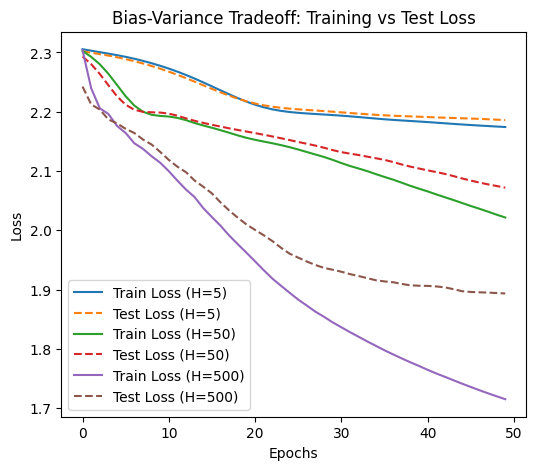

In [128]:
plt.figure(figsize=(6, 5))
for size, (_, train_loss, test_loss) in results.items():
    plt.plot(train_loss, label=f"Train Loss (H={size})")
    plt.plot(test_loss, '--', label=f"Test Loss (H={size})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Bias-Variance Tradeoff: Training vs Test Loss")
plt.show()

#### Evaluate models


In [129]:
#.argmax(1)
# ----------
# Finds the class with the highest score for each input sample.
# dim=1 means we take the max along columns (class dimension), returning the predicted class for each row (sample).

# (predicted == y)
# ----------------
# Compares predicted labels to true labels (y),
# returning a boolean tensor where True means correct prediction and False means incorrect.

def evaluate_model(model, x, y):
    with torch.no_grad():
        accuracy = (model(x).argmax(1) == y).float().mean().item()
    return accuracy

#### Loops over different models stored in the results dictionary.

In [130]:
print("\nFinal Model Performance:")

for size, model_data in results.items():
    model = model_data[0]  # Get the trained model
    train_acc = evaluate_model(model, x_train, y_train)
    test_acc = evaluate_model(model, x_test, y_test)
    print(f"Hidden Units: {size} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")


Final Model Performance:
Hidden Units: 5 | Train Acc: 25.28% | Test Acc: 23.40%
Hidden Units: 50 | Train Acc: 47.57% | Test Acc: 37.90%
Hidden Units: 500 | Train Acc: 78.05% | Test Acc: 57.30%


2️⃣Trian-validate-test split dataset
slice a set called validation set to optimize hyperparameters

In [35]:
# Convert to tensors
x_full = torch.tensor(data['x'], dtype=torch.float32)
y_full = torch.tensor(data['y'], dtype=torch.int64)
x_test = torch.tensor(data['x_test'], dtype=torch.float32)
y_test = torch.tensor(data['y_test'], dtype=torch.int64)

#### Split into train (70%), validation (15%), test (15%)

In [90]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(x_full, y_full, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

#### Define neural network

In [91]:
class SimpleNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(40, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.softmax(self.fc2(x))

#### Training the model

In [132]:
def train_model(hidden_size, lr, epochs=50):
    model = SimpleNN(hidden_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Train step
        optimizer.zero_grad()
        train_output = model(x_train)
        loss = criterion(train_output, y_train)
        loss.backward()
        optimizer.step()

        # Validation step
        with torch.no_grad():
            val_output = model(x_val)
            val_loss = criterion(val_output, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

    return model, train_losses, val_losses

####3️⃣ Hyperparameter tuning (testing different hidden sizes and learning rates)

In [135]:
hidden_sizes = [10, 50, 100]
learning_rates = [0.01, 0.001, 0.0001]
results = {}

for h_size in hidden_sizes:
    for lr in learning_rates:
        results[(h_size, lr)] = train_model(h_size, lr)


In [137]:
hyperparams = [(10, 0.01), (50, 0.001), (100, 0.0005)]
results = {}

for h_size, lr in hyperparams:
    results[(h_size, lr)] = train_model(h_size, lr)


#### Plot training vs validation loss

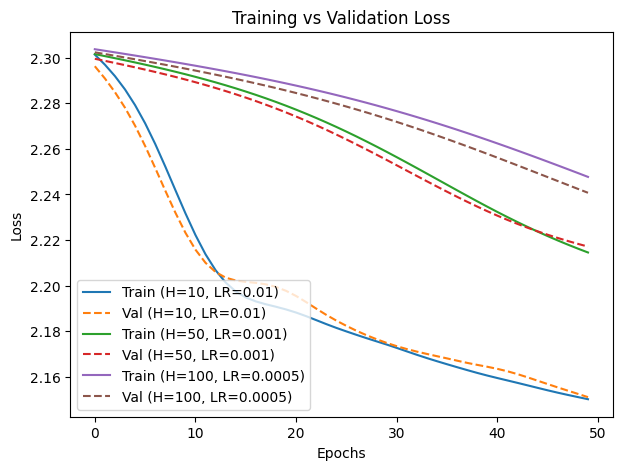

In [138]:
plt.figure(figsize=(7, 5))
for (h_size, lr), (_, train_loss, val_loss) in results.items():
    plt.plot(train_loss, label=f"Train (H={h_size}, LR={lr})")
    plt.plot(val_loss, '--', label=f"Val (H={h_size}, LR={lr})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### Find best model based on validation loss

In [139]:
best_config = min(results, key=lambda c: min(results[c][2]))  # Model with lowest validation loss
best_model = results[best_config][0]

#### 4️⃣ Evaluate the best model on the test set

In [140]:
with torch.no_grad():
    test_accuracy = (best_model(x_test).argmax(1) == y_test).float().mean().item()

print(f"Best Model {best_config} - Test Accuracy: {test_accuracy:.4f}")

Best Model (10, 0.01) - Test Accuracy: 0.2740


#### Sources :
#### 1- MNIST-1D Repo: https://github.com/greydanus/mnist1d/tree/master
#### 2- ch8 of simon UDL BOOK